# First Steps With Vessim

In this tutorial, we'll create our first scenario: a simulated server running on solar power with battery backup.

In [4]:
import vessim as vs

# For plotting results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Required for running Mosaic in Jupyter notebooks (fixes asyncio event loop conflicts)
import nest_asyncio
nest_asyncio.apply()

## Setting up the simulation

We'll create a simple microgrid with:

- **A server** that constantly uses 700W of power
- **A solar power system** that produces up to 5kW (using real weather data from Berlin in 2022)
- **A battery** that can store 1500Wh of energy (starts 80% charged, never goes below 50%)
- **A monitor** that writes all progress to a CSV file

The simulation will show us what happens over 24 hours on a day in June.

In [2]:
# Create the simulation environment
environment = vs.Environment(sim_start="2022-06-09 00:00:00")

# Add a single microgrid to the simulation
environment.add_microgrid(
    actors=[
        # Server that consumes 700W constantly
        vs.Actor(
            name="server",
            signal=vs.MockSignal(value=-700),  # negative = consumes power
        ),
        # Solar panel that produces up to 5kW based on the Berlin dataset provided by Solcast
        vs.Actor(
            name="solar_panel",
            signal=vs.HistoricalSignal.load(
                "solcast2022_global", 
                column="Berlin", 
                params={"scale": 5000}  # 5kW maximum
            ),
        ),
    ],
    controllers=[
        vs.Monitor(outfile="result.csv")  # Logs all relevant simulation data to a CSV file
    ],
    storage=vs.SimpleBattery(
        capacity=1500,      # 1500Wh capacity
        initial_soc=0.8,    # Start 80% charged
        min_soc=0.5         # Never go below 50%
    ),
    step_size=60,  # Simulates the microgrid in 60s steps
)

# Run the simulation for 24 hours
environment.run(until=24 * 3600)

2025-06-26 22:32:07.997 | INFO     | mosaik.async_scenario:start:361 - Starting "Actor" as "server" ...
2025-06-26 22:32:07.999 | INFO     | mosaik.async_scenario:start:361 - Starting "Actor" as "solar_panel" ...
2025-06-26 22:32:08.000 | INFO     | mosaik.async_scenario:start:361 - Starting "Grid" as "Grid-0" ...
2025-06-26 22:32:08.001 | INFO     | mosaik.async_scenario:start:361 - Starting "Controller" as "Monitor-0" ...
2025-06-26 22:32:08.002 | INFO     | mosaik.async_scenario:start:361 - Starting "Storage" as "Storage-0" ...
2025-06-26 22:32:08.004 | INFO     | mosaik.async_scenario:run:697 - Starting simulation.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:01<00:00, 53105.44steps/s]
2025-06-26 22:32:09.655 | INFO     | mosaik.async_scenario:run:753 - Simulation finished successfully.


## What happened?

Let's visualize the results to see the key patterns:

- **At night**: No solar power, so the battery provides power until it's depleted, then power comes from the grid
- **During the day**: Solar panels produce more power than the server needs, so excess energy charges the battery
- **Morning/evening**: Solar power gradually increases/decreases, creating interesting transitions

The chart below shows when power comes from solar (yellow) vs. the grid (blue).

In [6]:
df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)
df.head()

,p_delta,e_delta,server.p,solar_panel.p,policy.mode,policy.charge_power,storage.soc,storage.charge_level,storage.capacity,storage.min_soc,storage.c_rate
time,,,,,,,,,,,
2022-06-09 00:00:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.800000,1200.000000,1500,0.5,NaN
2022-06-09 00:01:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.792222,1188.333333,1500,0.5,NaN
2022-06-09 00:02:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.784444,1176.666667,1500,0.5,NaN
2022-06-09 00:03:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.776667,1165.000000,1500,0.5,NaN
2022-06-09 00:04:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.768889,1153.333333,1500,0.5,NaN


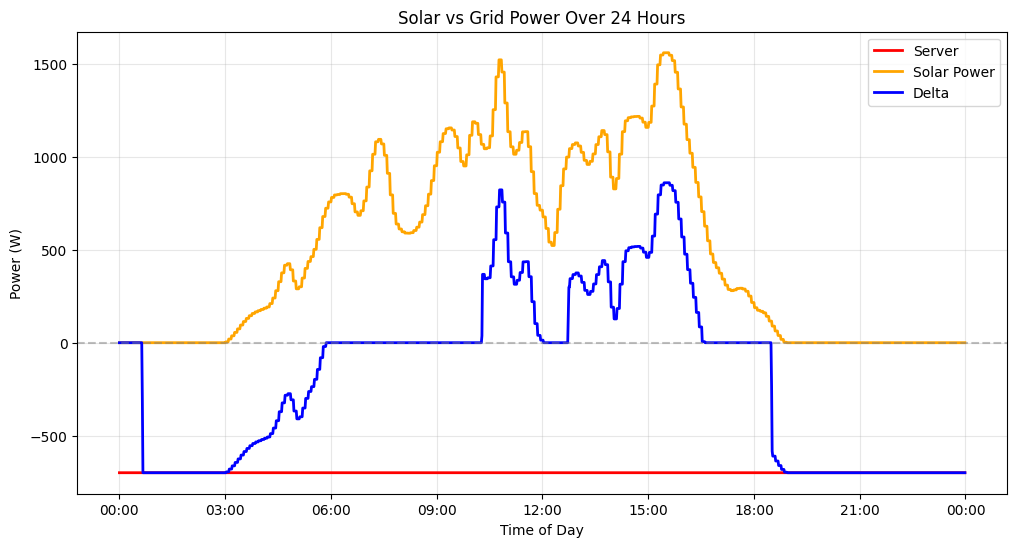

In [11]:
# Load the simulation results
df["grid_power"] = df["e_delta"] / 60  # Convert to power (W)

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot solar power and grid power
ax.plot(df.index, df["server.p"], color="red", label="Server", linewidth=2)
ax.plot(df.index, df["solar_panel.p"], color="orange", label="Solar Power", linewidth=2)
ax.plot(df.index, df["grid_power"], color="blue", label="Delta", linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Format the chart
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, alpha=0.3)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Power (W)")
ax.set_title("Solar vs Grid Power Over 24 Hours")
ax.legend()
plt.show()

In [ ]:
print("Key insights:")
print(f"- Maximum solar power: {df['solar_panel.p'].max():.0f}W")
print(f"- Server power consumption: 700W constant")
print(f"- Hours with excess solar: {len(df[df['solar_panel.p'] > 700])//60:.1f} hours")